In [90]:
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

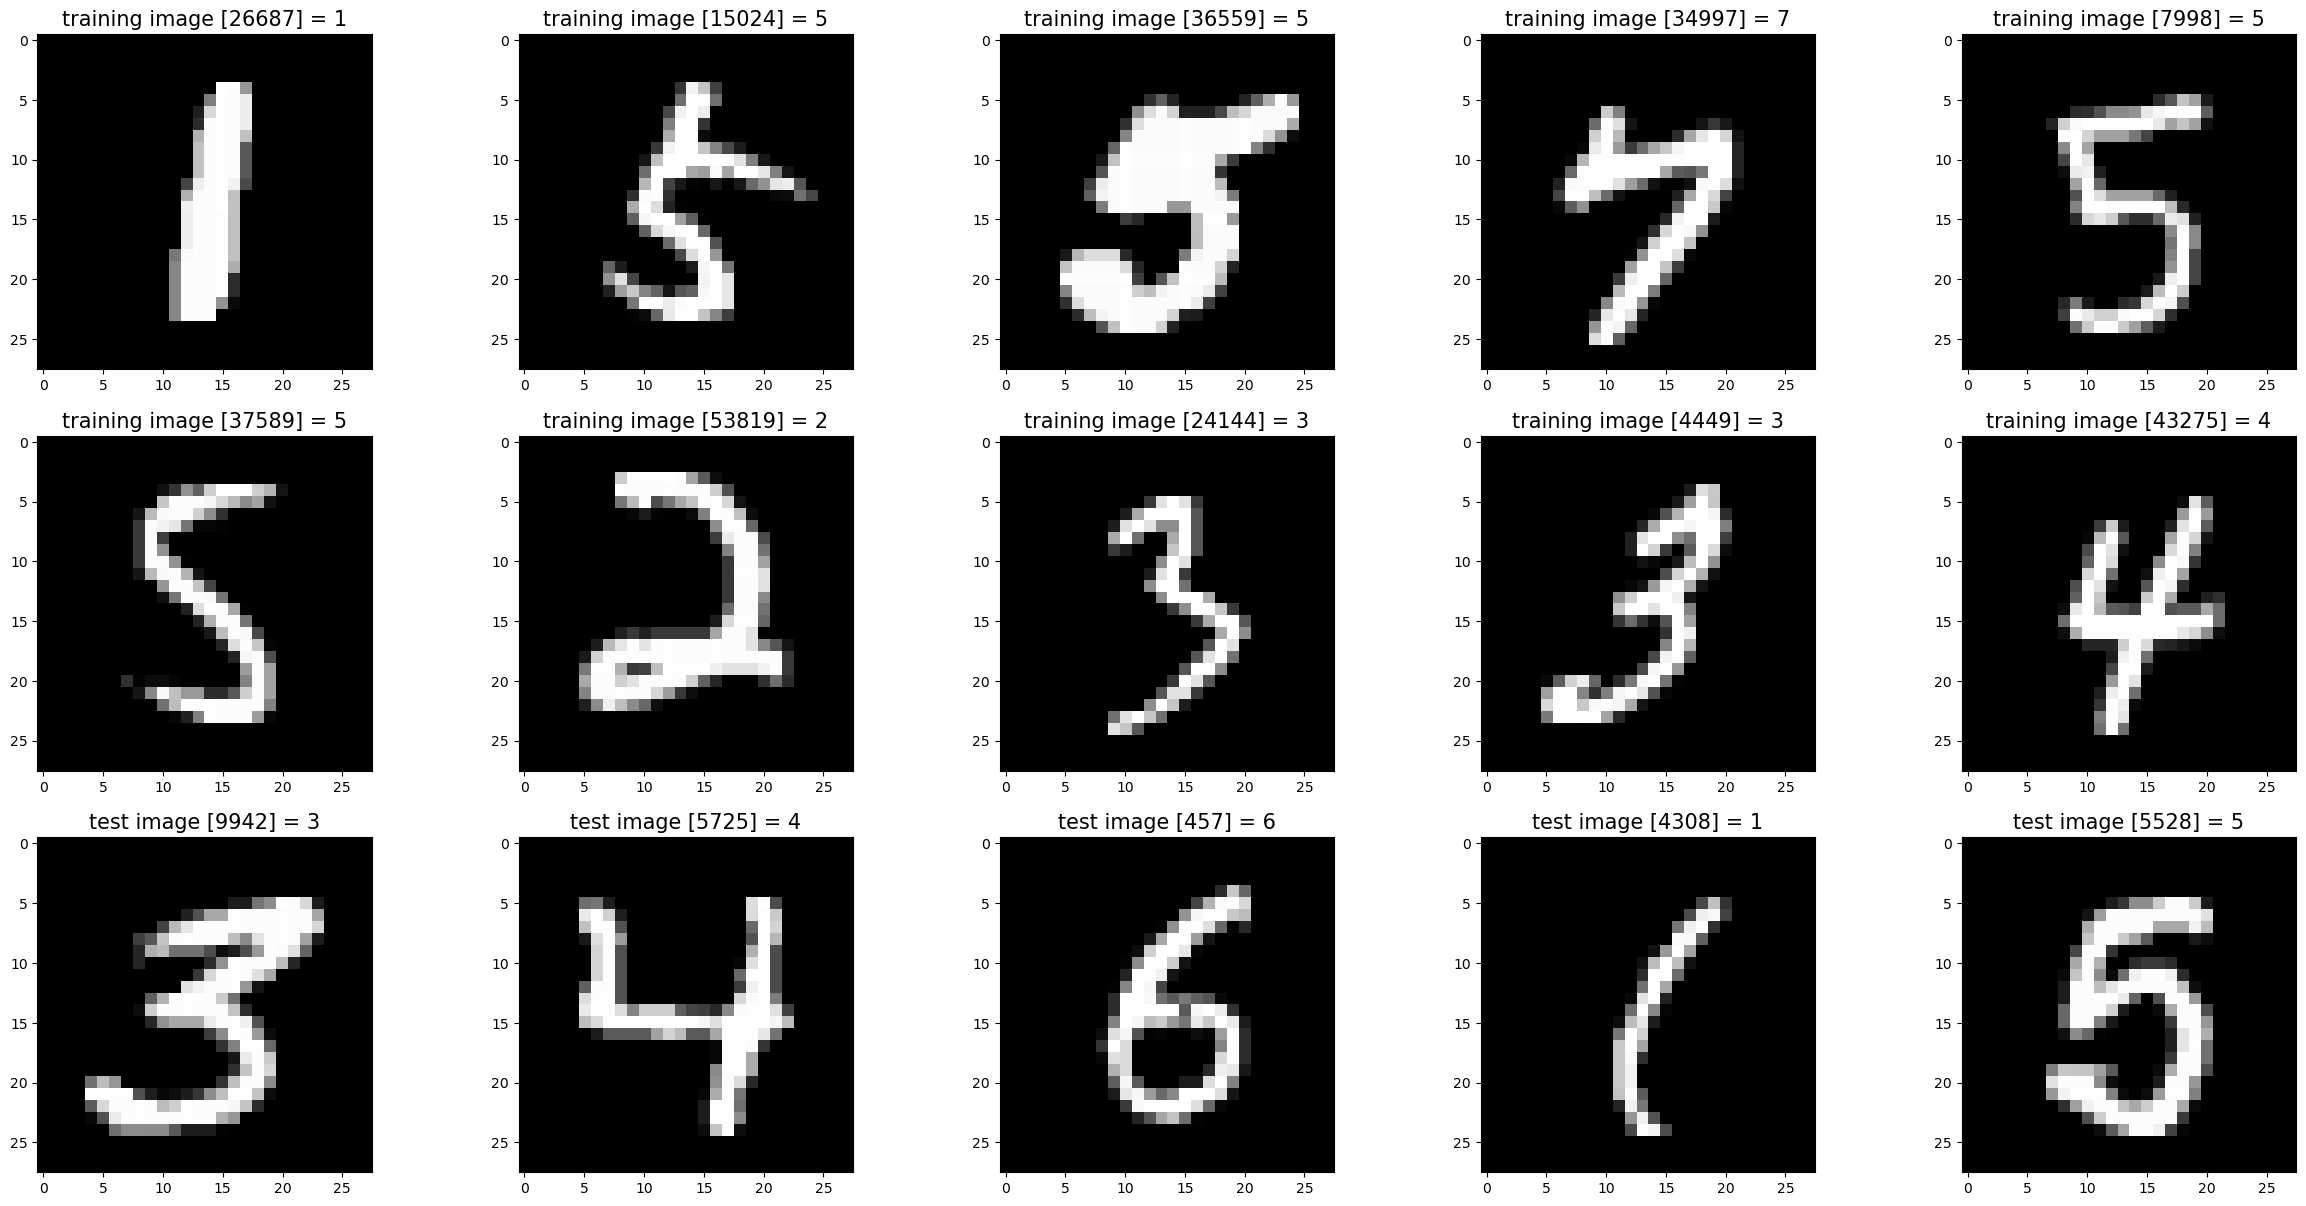

In [92]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'arquivos'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
    plt.show()
#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [93]:
x_train = cp.asarray(x_train)
y_train = cp.asarray(y_train)
x_test = cp.asarray(x_test)
y_test = cp.asarray(y_test)

x_train = x_train.reshape(x_train.shape[0], -1).T  
x_test = x_test.reshape(x_test.shape[0], -1).T
y_train = y_train.flatten()
y_test = y_test.flatten()

n_total = x_train.shape[1]  
indices = cp.arange(n_total)
cp.random.shuffle(indices)

x_train = x_train[:, indices]
y_train = y_train[indices]
val_size = int(n_total * 0.2)

x_val = x_train[:, :val_size]         
y_val = y_train[:val_size]

x_train_final = x_train[:, val_size:]  
y_train_final = y_train[val_size:]


REDE NEURAL USANDO CROSS ENTROPY LOSS

In [94]:
def ReLU(x):
    return cp.maximum(0, x)

def softmax(Z):
    expZ = cp.exp(Z - cp.max(Z, axis=0, keepdims=True))
    return expZ / cp.sum(expZ, axis=0, keepdims=True)

def deriv_ReLU(x):
    return x > 0

def one_hot(Y, num_classes=10):
    Y = cp.asarray(Y)
    one_hot_Y = cp.zeros((num_classes, Y.size))
    one_hot_Y[Y, cp.arange(Y.size)] = 1
    return one_hot_Y

def inicializar_parametros():
    W1 = cp.random.randn(64, 784) * 0.01
    b1 = cp.zeros((64, 1))
    W2 = cp.random.randn(10, 64) * 0.01
    b2 = cp.zeros((10, 1))
    return W1, b1, W2, b2

def forw_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = (1/m) * dZ2.dot(A1.T)
    db2 = (1/m) * cp.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = (1/m) * dZ1.dot(X.T)
    db1 = (1/m) * cp.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def atualizar_param(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 = W1 - dW1 * lr
    W2 = W2 - dW2 * lr
    b1 = b1 - db1 * lr
    b2 = b2 - db2 * lr
    return W1, b1, W2, b2

def compute_loss(A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    log_probs = cp.log(A2 + 1e-8)  # Adiciona epsilon para evitar log(0)
    loss = -cp.sum(one_hot_Y * log_probs) / m
    return loss


In [95]:
def prediction(x):
    return cp.argmax(x, axis=0)

def acc(pred, y):
    #print(pred, y)
    return cp.sum(pred == y) / y.size

def gradient_descent(X, Y,x_val, y_val, iterations, lr):
    W1, b1, W2, b2 = inicializar_parametros()
    train_accuracies = []
    val_accuracies = []
    steps = []
    train_losses = []
    val_losses = []

    for i in range(iterations):
        Z1, A1, Z2, A2 = forw_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = atualizar_param(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        if i % 10 == 0:
            _, _, _, A2_train = forw_prop(W1, b1, W2, b2, X)
            train_preds = prediction(A2_train)
            train_acc = acc(train_preds, Y)
            train_loss = compute_loss(A2_train, Y)

            _, _, _, A2_val = forw_prop(W1, b1, W2, b2, x_val)
            val_preds = prediction(A2_val)
            val_acc = acc(val_preds, y_val)
            val_loss = compute_loss(A2_val, y_val)

            steps.append(i)
            train_accuracies.append(cp.asnumpy(train_acc))
            val_accuracies.append(cp.asnumpy(val_acc))
            train_losses.append(cp.asnumpy(train_loss))
            val_losses.append(cp.asnumpy(val_loss))
            

            print(f"Iter {i}: acc_treino={train_acc:.4f}, acc_val={val_acc:.4f}, "
                  f"loss_treino={train_loss:.4f}, loss_val={val_loss:.4f}")
    return W1, b1, W2, b2, steps, train_accuracies, val_accuracies, train_losses, val_losses

In [96]:
def stochastic_grad(X, Y,x_val, y_val, lr, batch, epochs):
    W1, b1, W2, b2 = inicializar_parametros()
    train_accuracies = []
    val_accuracies = []
    steps = []
    train_losses = []
    val_losses = []
    best_val_acc = -1
    best_params = None
    
    m = X.shape[1]

    for epoch in range(epochs):
        indices = cp.random.permutation(m)
        X_shuffled = X[:, indices]
        Y_shuffled = Y[indices]

        
        for i in range(0, m, batch):
            X_batch = X_shuffled[:, i:i+batch]
            Y_batch = Y_shuffled[i:i+batch]

            Z1, A1, Z2, A2 = forw_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            batch_len = Y_batch.size
            dW1 /= batch_len
            db1 /= batch_len
            dW2 /= batch_len
            db2 /= batch_len

            # Atualiza os parâmetros
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2
        
        if epoch % 10 == 0:
            _, _, _, A2_train = forw_prop(W1, b1, W2, b2, X)
            train_preds = prediction(A2_train)
            train_acc = acc(train_preds, Y)
            train_loss = compute_loss(A2_train, Y)

            _, _, _, A2_val = forw_prop(W1, b1, W2, b2, x_val)
            val_preds = prediction(A2_val)
            val_acc = acc(val_preds, y_val)
            val_loss = compute_loss(A2_val, y_val)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {
                    "W1": W1.copy(),
                    "b1": b1.copy(),
                    "W2": W2.copy(),
                    "b2": b2.copy(),
                    "epoch": epoch,
                    "val_acc": val_acc,
                }

            steps.append(epoch)
            train_accuracies.append(cp.asnumpy(train_acc))
            val_accuracies.append(cp.asnumpy(val_acc))
            train_losses.append(cp.asnumpy(train_loss))
            val_losses.append(cp.asnumpy(val_loss))

            print(f"Iter {epoch}: acc_treino={train_acc:.4f}, acc_val={val_acc:.4f}, "
                  f"loss_treino={train_loss:.4f}, loss_val={val_loss:.4f}")
    return best_params, steps, train_accuracies, val_accuracies, train_losses, val_losses

In [97]:
def adam(X, Y,x_val, y_val, lr, batch, epochs, eps, beta, gamma):
    W1, b1, W2, b2 = inicializar_parametros()
    train_accuracies = []
    val_accuracies = []
    steps = []
    train_losses = []
    val_losses = []
    best_val_acc = -1
    best_params = None
    m = X.shape[1]
    t = 0

    mW1 = np.zeros_like(W1)
    mb1 = np.zeros_like(b1)
    mW2 = np.zeros_like(W2)
    mb2 = np.zeros_like(b2)

    vW1 = np.zeros_like(W1)
    vb1 = np.zeros_like(b1)
    vW2 = np.zeros_like(W2)
    vb2 = np.zeros_like(b2)

    for epoch in range(epochs):
        indices = cp.random.permutation(m)
        X_shuffled = X[:, indices]
        Y_shuffled = Y[indices]
        t += 1
        
        for i in range(0, m, batch):
            X_batch = X_shuffled[:, i:i+batch]
            Y_batch = Y_shuffled[i:i+batch]

            Z1, A1, Z2, A2 = forw_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            batch_len = Y_batch.size

            mW1 = beta * mW1 + (1 - beta) * dW1
            mb1 = beta * mb1 + (1 - beta) * db1
            mW2 = beta * mW2 + (1 - beta) * dW2
            mb2 = beta * mb2 + (1 - beta) * db2

            vW1 = gamma * vW1 + (1 - gamma) * (dW1**2)
            vb1 = gamma * vb1 + (1 - gamma) * (db1**2)
            vW2 = gamma * vW2 + (1 - gamma) * (dW2**2)
            vb2 = gamma * vb2 + (1 - gamma) * (db2**2)

            mW1_corr = mW1 / (1 - beta**t)
            mb1_corr = mb1 / (1 - beta**t)
            mW2_corr = mW2 / (1 - beta**t)
            mb2_corr = mb2 / (1 - beta**t)

            vW1_corr = vW1 / (1 - gamma**t)
            vb1_corr = vb1 / (1 - gamma**t)
            vW2_corr = vW2 / (1 - gamma**t)
            vb2_corr = vb2 / (1 - gamma**t)

              
            W1 -= lr * mW1_corr / (np.sqrt(vW1_corr) + eps)
            b1 -= lr * mb1_corr / (np.sqrt(vb1_corr) + eps)
            W2 -= lr * mW2_corr / (np.sqrt(vW2_corr) + eps)
            b2 -= lr * mb2_corr / (np.sqrt(vb2_corr) + eps)
        
        if epoch % 10 == 0:
            _, _, _, A2_train = forw_prop(W1, b1, W2, b2, X)
            train_preds = prediction(A2_train)
            train_acc = acc(train_preds, Y)
            train_loss = compute_loss(A2_train, Y)

            _, _, _, A2_val = forw_prop(W1, b1, W2, b2, x_val)
            val_preds = prediction(A2_val)
            val_acc = acc(val_preds, y_val)
            val_loss = compute_loss(A2_val, y_val)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {
                    "W1": W1.copy(),
                    "b1": b1.copy(),
                    "W2": W2.copy(),
                    "b2": b2.copy(),
                    "epoch": epoch,
                    "val_acc": val_acc,
                }

            steps.append(epoch)
            train_accuracies.append(cp.asnumpy(train_acc))
            val_accuracies.append(cp.asnumpy(val_acc))
            train_losses.append(cp.asnumpy(train_loss))
            val_losses.append(cp.asnumpy(val_loss))

            print(f"Iter {epoch}: acc_treino={train_acc:.4f}, acc_val={val_acc:.4f}, "
                  f"loss_treino={train_loss:.4f}, loss_val={val_loss:.4f}")
    return best_params, steps, train_accuracies, val_accuracies, train_losses, val_losses

In [98]:
def momentum_stch_grad_desc(X, Y,x_val, y_val, lr, batch, epochs, beta):
    W1, b1, W2, b2 = inicializar_parametros()
    train_accuracies = []
    val_accuracies = []
    steps = []
    train_losses = []
    val_losses = []
    best_val_acc = -1
    best_params = None
    momentum_W1 = cp.zeros_like(W1)
    momentum_b1 = cp.zeros_like(b1)
    momentum_W2 = cp.zeros_like(W2)
    momentum_b2 = cp.zeros_like(b2)
    m = X.shape[1]

    for epoch in range(epochs):
        indices = cp.random.permutation(m)
        X_shuffled = X[:, indices]
        Y_shuffled = Y[indices]

        
        for i in range(0, m, batch):
            X_batch = X_shuffled[:, i:i+batch]
            Y_batch = Y_shuffled[i:i+batch]

            Z1, A1, Z2, A2 = forw_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            batch_len = Y_batch.size

            momentum_W1 = momentum_W1*beta + (1-beta)*dW1
            momentum_b1 = momentum_b1*beta + (1-beta)*db1
            momentum_W2 = momentum_W2*beta + (1-beta)*dW2
            momentum_b2 = momentum_b2*beta + (1-beta)*db2

            """momentum_W1 /= batch_len
            momentum_b1 /= batch_len
            momentum_W2 /= batch_len
            momentum_b2 /= batch_len"""

            
            W1 -= lr * momentum_W1
            b1 -= lr * momentum_b1
            W2 -= lr * momentum_W2
            b2 -= lr * momentum_b2
        
        if epoch % 10 == 0:
            _, _, _, A2_train = forw_prop(W1, b1, W2, b2, X)
            train_preds = prediction(A2_train)
            train_acc = acc(train_preds, Y)
            train_loss = compute_loss(A2_train, Y)

            _, _, _, A2_val = forw_prop(W1, b1, W2, b2, x_val)
            val_preds = prediction(A2_val)
            val_acc = acc(val_preds, y_val)
            val_loss = compute_loss(A2_val, y_val)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {
                    "W1": W1.copy(),
                    "b1": b1.copy(),
                    "W2": W2.copy(),
                    "b2": b2.copy(),
                    "epoch": epoch,
                    "val_acc": val_acc,
                }

            steps.append(epoch)
            train_accuracies.append(cp.asnumpy(train_acc))
            val_accuracies.append(cp.asnumpy(val_acc))
            train_losses.append(cp.asnumpy(train_loss))
            val_losses.append(cp.asnumpy(val_loss))

            print(f"Iter {epoch}: acc_treino={train_acc:.4f}, acc_val={val_acc:.4f}, "
                  f"loss_treino={train_loss:.4f}, loss_val={val_loss:.4f}")
    return best_params, steps, train_accuracies, val_accuracies, train_losses, val_losses

In [99]:
best_params_adam, steps_adam, train_accs_adam, val_accs_adam, train_losses_adam, val_losses_adam = adam(
    x_train_final, y_train_final, x_val, y_val, lr=0.001, batch=32, epochs=200,eps = 1e-8, beta=0.9, gamma=0.999
)

W1_adam = best_params_adam["W1"]
b1_adam = best_params_adam["b1"]
W2_adam = best_params_adam["W2"]
b2_adam = best_params_adam["b2"]

Iter 0: acc_treino=0.9516, acc_val=0.9417, loss_treino=0.1613, loss_val=0.1980
Iter 10: acc_treino=0.9931, acc_val=0.9653, loss_treino=0.0225, loss_val=0.1487
Iter 20: acc_treino=0.9963, acc_val=0.9646, loss_treino=0.0110, loss_val=0.1995
Iter 30: acc_treino=0.9972, acc_val=0.9633, loss_treino=0.0092, loss_val=0.2516
Iter 40: acc_treino=0.9959, acc_val=0.9659, loss_treino=0.0124, loss_val=0.2684
Iter 50: acc_treino=0.9947, acc_val=0.9648, loss_treino=0.0202, loss_val=0.3025
Iter 60: acc_treino=0.9950, acc_val=0.9611, loss_treino=0.0192, loss_val=0.3633
Iter 70: acc_treino=0.9966, acc_val=0.9657, loss_treino=0.0137, loss_val=0.3506
Iter 80: acc_treino=0.9968, acc_val=0.9637, loss_treino=0.0134, loss_val=0.3939
Iter 90: acc_treino=0.9960, acc_val=0.9644, loss_treino=0.0197, loss_val=0.4105
Iter 100: acc_treino=0.9936, acc_val=0.9636, loss_treino=0.0375, loss_val=0.4345
Iter 110: acc_treino=0.9966, acc_val=0.9658, loss_treino=0.0242, loss_val=0.4220
Iter 120: acc_treino=0.9983, acc_val=0.

In [100]:
best_params_momentum, steps_momentum, train_accs_momentum, val_accs_momentum, train_losses_momentum, val_losses_momentum = momentum_stch_grad_desc(
    x_train_final, y_train_final, x_val, y_val, lr=0.01, batch=32, epochs=150, beta=0.99999
)

W1_mom = best_params_momentum["W1"]
b1_mom = best_params_momentum["b1"]
W2_mom = best_params_momentum["W2"]
b2_mom = best_params_momentum["b2"]

Iter 0: acc_treino=0.8499, acc_val=0.8554, loss_treino=0.6520, loss_val=0.6421
Iter 10: acc_treino=0.8907, acc_val=0.8860, loss_treino=0.4406, loss_val=0.5196
Iter 20: acc_treino=0.9032, acc_val=0.8952, loss_treino=0.4133, loss_val=0.5275
Iter 30: acc_treino=0.9008, acc_val=0.8898, loss_treino=0.4089, loss_val=0.5681
Iter 40: acc_treino=0.9061, acc_val=0.8935, loss_treino=0.3953, loss_val=0.6041
Iter 50: acc_treino=0.8939, acc_val=0.8797, loss_treino=0.4020, loss_val=0.6064
Iter 60: acc_treino=0.8839, acc_val=0.8723, loss_treino=0.4060, loss_val=0.5984
Iter 70: acc_treino=0.8829, acc_val=0.8678, loss_treino=0.4079, loss_val=0.6271
Iter 80: acc_treino=0.8584, acc_val=0.8460, loss_treino=0.4425, loss_val=0.6536
Iter 90: acc_treino=0.8635, acc_val=0.8488, loss_treino=0.4393, loss_val=0.6372
Iter 100: acc_treino=0.8699, acc_val=0.8568, loss_treino=0.4055, loss_val=0.6208
Iter 110: acc_treino=0.8633, acc_val=0.8504, loss_treino=0.3973, loss_val=0.6004
Iter 120: acc_treino=0.8875, acc_val=0.

In [101]:
best_params_stoch, steps_stoch, train_accs_stoch, val_accs_stoch, train_losses_stoch, val_losses_stoch = stochastic_grad(
    x_train_final, y_train_final, x_val, y_val, lr=0.01, batch=32, epochs=150
)

W1_stoch = best_params_stoch["W1"]
b1_stoch = best_params_stoch["b1"]
W2_stoch = best_params_stoch["W2"]
b2_stoch = best_params_stoch["b2"]

Iter 0: acc_treino=0.9322, acc_val=0.9271, loss_treino=0.2343, loss_val=0.2534
Iter 10: acc_treino=0.9854, acc_val=0.9664, loss_treino=0.0536, loss_val=0.1112
Iter 20: acc_treino=0.9943, acc_val=0.9689, loss_treino=0.0254, loss_val=0.1094
Iter 30: acc_treino=0.9990, acc_val=0.9692, loss_treino=0.0113, loss_val=0.1142
Iter 40: acc_treino=0.9996, acc_val=0.9702, loss_treino=0.0061, loss_val=0.1206
Iter 50: acc_treino=1.0000, acc_val=0.9702, loss_treino=0.0037, loss_val=0.1246
Iter 60: acc_treino=1.0000, acc_val=0.9714, loss_treino=0.0025, loss_val=0.1294
Iter 70: acc_treino=1.0000, acc_val=0.9706, loss_treino=0.0020, loss_val=0.1336
Iter 80: acc_treino=1.0000, acc_val=0.9712, loss_treino=0.0015, loss_val=0.1356
Iter 90: acc_treino=1.0000, acc_val=0.9707, loss_treino=0.0013, loss_val=0.1380
Iter 100: acc_treino=1.0000, acc_val=0.9705, loss_treino=0.0011, loss_val=0.1409
Iter 110: acc_treino=1.0000, acc_val=0.9707, loss_treino=0.0009, loss_val=0.1429
Iter 120: acc_treino=1.0000, acc_val=0.

In [102]:
print("x_train_final:", x_train_final.shape)
print("y_train_final:", y_train_final.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)


x_train_final: (784, 48000)
y_train_final: (48000,)
x_val: (784, 12000)
y_val: (12000,)


In [103]:
W1, b1, W2, b2, steps, train_accs, val_accs, train_losses, val_losses = gradient_descent(
    x_train_final, y_train_final, x_val, y_val, iterations=5000, lr=0.001
)

Iter 0: acc_treino=0.2050, acc_val=0.2027, loss_treino=2.6076, loss_val=2.5954
Iter 10: acc_treino=0.6992, acc_val=0.7028, loss_treino=1.0554, loss_val=1.0601
Iter 20: acc_treino=0.7886, acc_val=0.7913, loss_treino=0.7274, loss_val=0.7326
Iter 30: acc_treino=0.8244, acc_val=0.8281, loss_treino=0.5977, loss_val=0.6028
Iter 40: acc_treino=0.8422, acc_val=0.8462, loss_treino=0.5291, loss_val=0.5342
Iter 50: acc_treino=0.8554, acc_val=0.8592, loss_treino=0.4862, loss_val=0.4913
Iter 60: acc_treino=0.8643, acc_val=0.8678, loss_treino=0.4562, loss_val=0.4615
Iter 70: acc_treino=0.8714, acc_val=0.8749, loss_treino=0.4338, loss_val=0.4393
Iter 80: acc_treino=0.8765, acc_val=0.8814, loss_treino=0.4162, loss_val=0.4220
Iter 90: acc_treino=0.8806, acc_val=0.8853, loss_treino=0.4018, loss_val=0.4079
Iter 100: acc_treino=0.8848, acc_val=0.8882, loss_treino=0.3896, loss_val=0.3962
Iter 110: acc_treino=0.8880, acc_val=0.8912, loss_treino=0.3792, loss_val=0.3861
Iter 120: acc_treino=0.8911, acc_val=0.

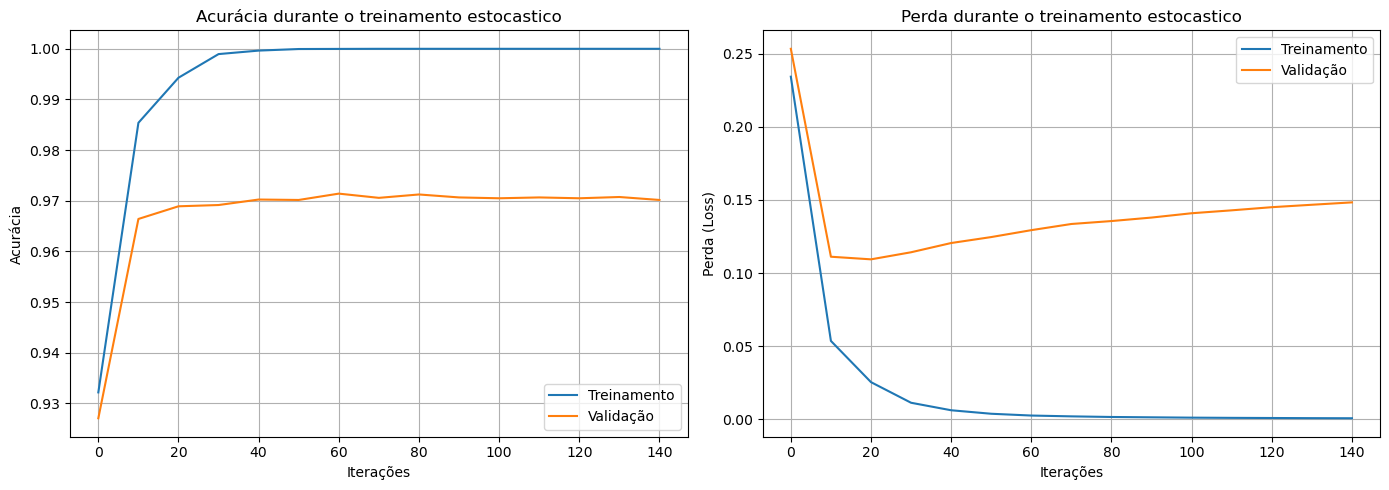

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(steps_stoch, train_accs_stoch, label='Treinamento')
plt.plot(steps_stoch, val_accs_stoch, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Acurácia")
plt.title("Acurácia durante o treinamento estocastico")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(steps_stoch, train_losses_stoch, label='Treinamento')
plt.plot(steps_stoch, val_losses_stoch, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Perda (Loss)")
plt.title("Perda durante o treinamento estocastico")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


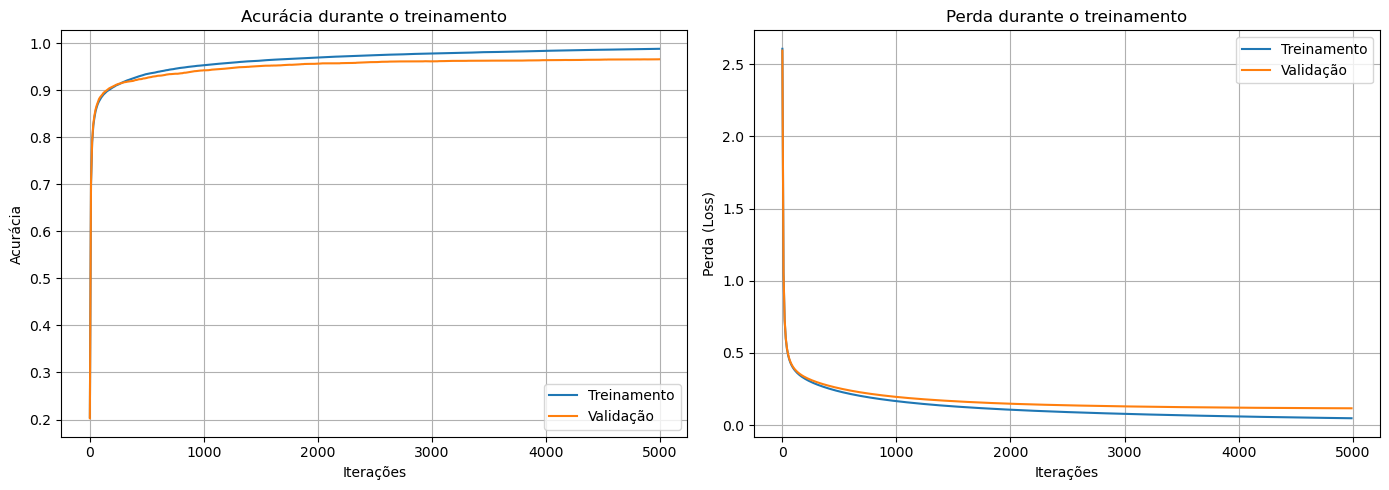

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(steps, train_accs, label='Treinamento')
plt.plot(steps, val_accs, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Acurácia")
plt.title("Acurácia durante o treinamento")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(steps, train_losses, label='Treinamento')
plt.plot(steps, val_losses, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Perda (Loss)")
plt.title("Perda durante o treinamento")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


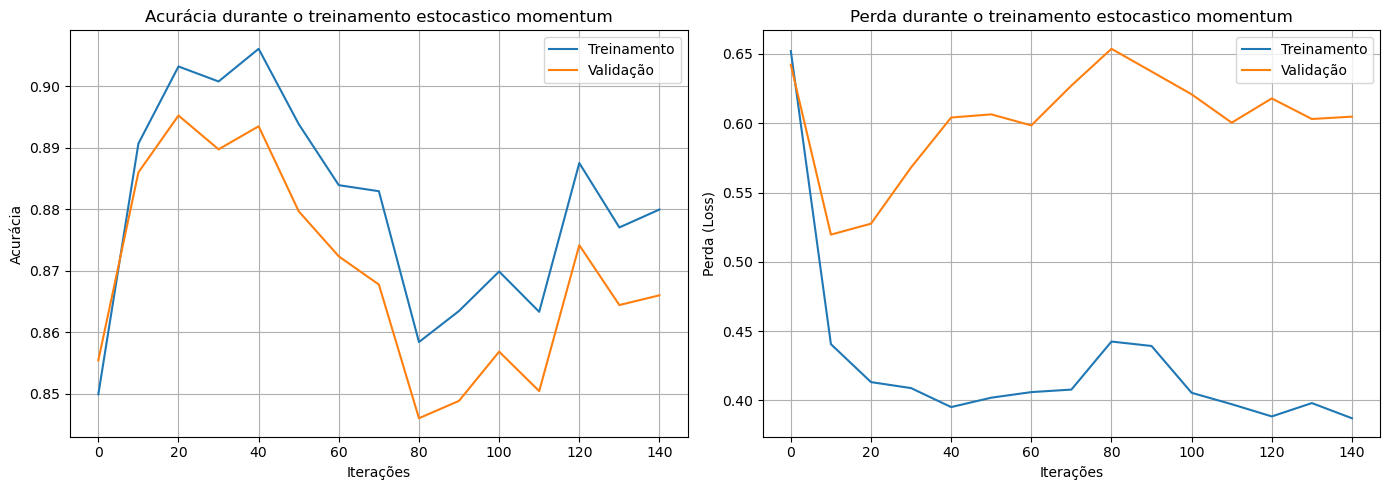

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(steps_momentum, train_accs_momentum, label='Treinamento')
plt.plot(steps_momentum, val_accs_momentum, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Acurácia")
plt.title("Acurácia durante o treinamento estocastico momentum")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(steps_momentum, train_losses_momentum, label='Treinamento')
plt.plot(steps_momentum, val_losses_momentum, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Perda (Loss)")
plt.title("Perda durante o treinamento estocastico momentum")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


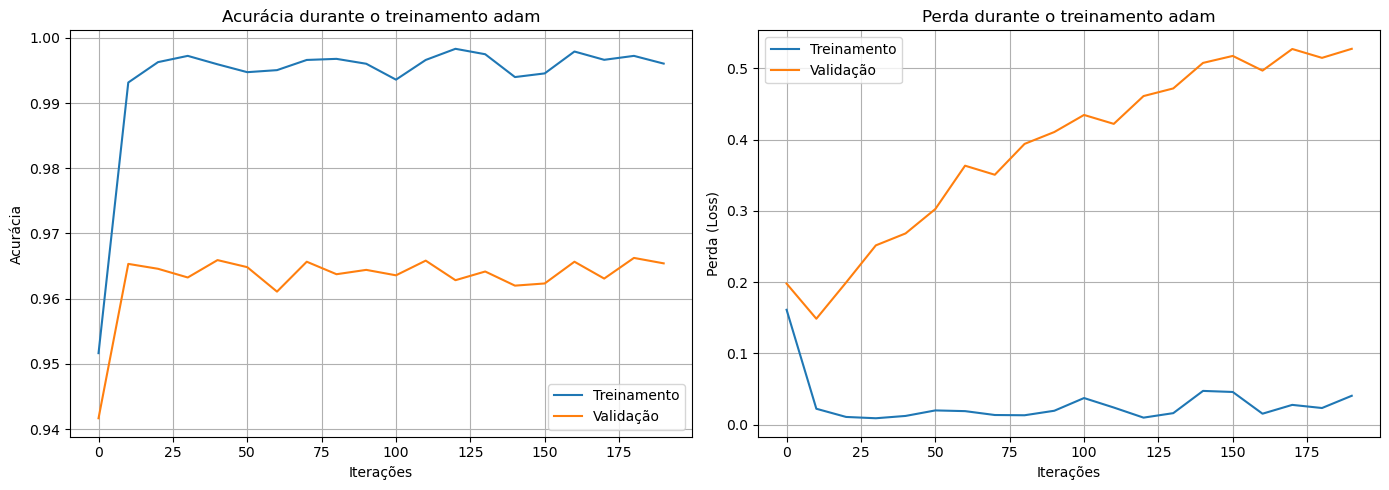

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(steps_adam, train_accs_adam, label='Treinamento')
plt.plot(steps_adam, val_accs_adam, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Acurácia")
plt.title("Acurácia durante o treinamento adam")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(steps_adam, train_losses_adam, label='Treinamento')
plt.plot(steps_adam, val_losses_adam, label='Validação')
plt.xlabel("Iterações")
plt.ylabel("Perda (Loss)")
plt.title("Perda durante o treinamento adam")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [108]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forw_prop(W1, b1, W2, b2, X)
    predictions = prediction(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)).get() * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


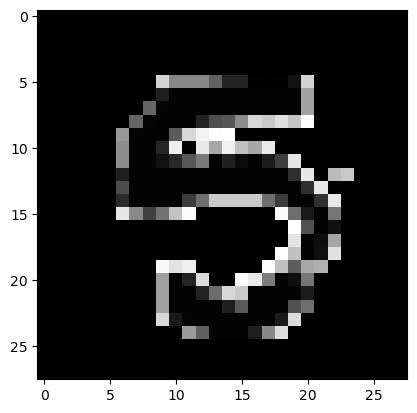

Prediction:  [4]
Label:  4


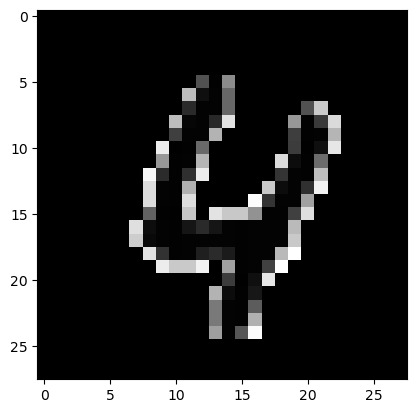

Prediction:  [4]
Label:  4


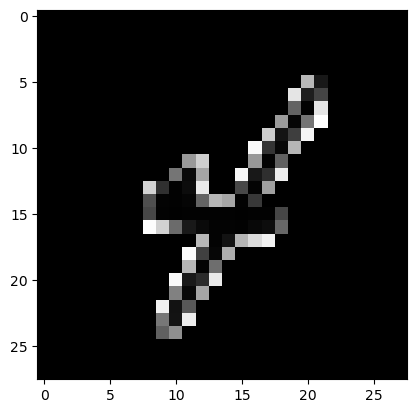

Prediction:  [0]
Label:  0


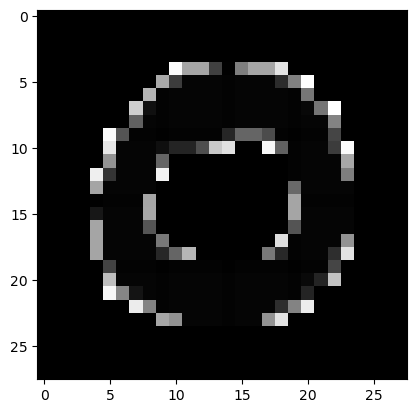

In [109]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)


teste gradient desc


In [110]:
dev_predictions = make_predictions(x_test, W1, b1, W2, b2)
acc(dev_predictions, y_test)

array(0.9689)

test stochastic grad desc

In [111]:
dev_predictions_stoch = make_predictions(x_test, W1_stoch, b1_stoch, W2_stoch, b2_stoch)
acc(dev_predictions_stoch, y_test)

array(0.9737)

teste momentum


In [112]:
dev_predictions_mom = make_predictions(x_test, W1_mom, b1_mom, W2_mom, b2_mom)
acc(dev_predictions_mom, y_test)

array(0.895)

teste adam


In [113]:
dev_predictions_adam = make_predictions(x_test, W1_adam, b1_adam, W2_adam, b2_adam)
acc(dev_predictions_adam, y_test)

array(0.9672)